# A Beginner’s Guide to Carry out Extreme Value Analysis (3)

This is the third part of "A Beginner’s Guide to Carry out Extreme Value Analysis". Upon the part 2 of this guide, we know  the GEV is the best one.

In this part, a bootstrapping procedure is introduced to drive the confidence intervals of the selected best extreme distribution.

## 1. Lets start by firing up the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D
import lmoments

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

## 2. Load data

In [2]:
data = pd.read_csv('fortprec.txt', sep ='\t')
df = data.groupby("year").Prec.max()

## 3. Fit GEV distribution (the best one)

In [3]:
LMU    = lmoments.samlmu(df)
gevfit = lmoments.pelgev(LMU)

gevfit

[1.3536800222811287, 0.55683475793448467, -0.13012477387318533]

## 4. Bootstrap confidence intervals

The calculations used a percentile interval method. The underlying idea is to 
* sample the orignal data as many as possible;
* carry out extreme value analysis on these sampled samples;
* do statistics such as means and percentiles.

All the code in this section has been adapted and simplified from that on 
* https://github.com/cgevans/scikits-bootstrap.
* https://github.com/kikocorreoso/scikit-extremes/blob/master/skextremes

All the credits shall go to them and you can find more information within each function.

In [4]:
import warnings as _warnings
from collections import OrderedDict
from numpy.random import randint as _randint

class InstabilityWarning(UserWarning):
    """Issued when results may be unstable."""
    pass

On import, make sure that InstabilityWarnings are not filtered out.

In [5]:
_warnings.simplefilter('always', InstabilityWarning)
_warnings.simplefilter('always', UserWarning)

The bootstrap_ci is the worker to carry out a series of tasks:
* sampling
* fitting gev distribution agaist samples
* do statistics

In [6]:
def bootstrap_ci(data, statfunction=np.average, alpha = 0.05, 
                 n_samples = 100):
    """
    Given a set of data ``data``, and a statistics function ``statfunction`` that
    applies to that data, computes the bootstrap confidence interval for
    ``statfunction`` on that data. Data points are assumed to be delineated by
    axis 0.
    
    This function has been derived and simplified from scikits-bootstrap 
    package created by cgevans (https://github.com/cgevans/scikits-bootstrap).
    All the credits shall go to him.
    **Parameters**
    
    data : array_like, shape (N, ...) OR tuple of array_like all with shape (N, ...)
        Input data. Data points are assumed to be delineated by axis 0. Beyond this,
        the shape doesn't matter, so long as ``statfunction`` can be applied to the
        array. If a tuple of array_likes is passed, then samples from each array (along
        axis 0) are passed in order as separate parameters to the statfunction. The
        type of data (single array or tuple of arrays) can be explicitly specified
        by the multi parameter.
    statfunction : function (data, weights = (weights, optional)) -> value
        This function should accept samples of data from ``data``. It is applied
        to these samples individually. 
    alpha : float, optional
        The percentiles to use for the confidence interval (default=0.05). The 
        returned values are (alpha/2, 1-alpha/2) percentile confidence
        intervals. 
    n_samples : int or float, optional
        The number of bootstrap samples to use (default=100)
        
    **Returns**
    
    confidences : tuple of floats
        The confidence percentiles specified by alpha
    **Calculation Methods**
    
    'pi' : Percentile Interval (Efron 13.3)
        The percentile interval method simply returns the 100*alphath bootstrap
        sample's values for the statistic. This is an extremely simple method of 
        confidence interval calculation. However, it has several disadvantages 
        compared to the bias-corrected accelerated method.
        
        If you want to use more complex calculation methods, please, see
        `scikits-bootstrap package 
        <https://github.com/cgevans/scikits-bootstrap>`_.
    **References**
    
        Efron (1993): 'An Introduction to the Bootstrap', Chapman & Hall.
    """

    def bootstrap_indexes(data, n_samples=10000):
        """
    Given data points data, where axis 0 is considered to delineate points, return
    an generator for sets of bootstrap indexes. This can be used as a list
    of bootstrap indexes (with list(bootstrap_indexes(data))) as well.
        """
        for _ in range(n_samples):
            yield _randint(data.shape[0], size=(data.shape[0],))    
    
    alphas = np.array([alpha / 2,1 - alpha / 2])

    data = np.array(data)
    tdata = (data,)
    
    # We don't need to generate actual samples; that would take more memory.
    # Instead, we can generate just the indexes, and then apply the statfun
    # to those indexes.
    bootindexes = bootstrap_indexes(tdata[0], n_samples)
    stat = np.array([statfunction(*(x[indexes] for x in tdata)) for indexes in bootindexes])
    stat.sort(axis=0)

    # Percentile Interval Method
    avals = alphas

    nvals = np.round((n_samples - 1)*avals).astype('int')

    if np.any(nvals == 0) or np.any(nvals == n_samples - 1):
        _warnings.warn("Some values used extremal samples; results are probably unstable.", InstabilityWarning)
    elif np.any(nvals<10) or np.any(nvals>=n_samples-10):
        _warnings.warn("Some values used top 10 low/high samples; results may be unstable.", InstabilityWarning)

    if nvals.ndim == 1:
        # All nvals are the same. Simple broadcasting
        return stat[nvals]
    else:
        # Nvals are different for each data point. Not simple broadcasting.
        # Each set of nvals along axis 0 corresponds to the data at the same
        # point in other axes.
        return stat[(nvals, np.indices(nvals.shape)[1:].squeeze())]

ci_bootstrap is the entry function of bootstrapping, who invoke the bootstrap_ci to do real work. 

In [7]:
def ci_bootstrap(df, gevfit):
    # Calculate confidence intervals using parametric bootstrap and the
    # percentil interval method
    # This is used to obtain confidence intervals for the estimators and
    # the return values for several return values.    
    # More info about bootstrapping can be found on:
    #     - https://github.com/cgevans/scikits-bootstrap
    #     - Efron: "An Introduction to the Bootstrap", Chapman & Hall (1993)
    #     - https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29

    # parametric bootstrap for return levels and parameters   

    # The function to bootstrap     
    def func(data):
        sample = lmoments.randgev(len(df.index), gevfit)
        samgevfit = lmoments.pelgev(lmoments.samlmu(sample))      
                
        T = np.arange(0.1, 999.1, 0.1) + 1
        sT = lmoments.quagev(1.0-1./T, samgevfit)
        res = samgevfit
        res.extend(sT.tolist())
        return tuple(res)

    # the calculations itself
    out = bootstrap_ci(df, statfunction = func, n_samples = 500)
    ci_Td = out[0, 3:]
    ci_Tu = out[1, 3:]
    params_ci = OrderedDict()
    params_ci['shape']    = (out[0,0], out[1,0])
    params_ci['location'] = (out[0,1], out[1,1])
    params_ci['scale']    = (out[0,2], out[1,3])
    
    return{'ci_Td':ci_Td, 'ci_Tu':ci_Tu, 'params_ci':params_ci}

## 5. Get extreme precipitation according to some return years

In [8]:
# return years (1.1 to 1000)
T  = np.arange(0.1, 999.1, 0.1) + 1
sT = lmoments.quagev(1.0-1./T, gevfit)

# prepare index for obs
N    = np.r_[1:len(df.index)+1]*1.0 #must *1.0 to convert int to float
Nmax = max(N)

# get confidence intervals
bootout   = ci_bootstrap(df, gevfit)
ci_Td     = bootout["ci_Td"]
ci_Tu     = bootout["ci_Tu"]
params_ci = bootout["params_ci"]

params_ci

OrderedDict([('shape', (1.2342415170938525, 1.5011825992644816)),
             ('location', (0.45818228211018025, 0.66680788425871662)),
             ('scale', (-0.28169197632867771, 1.0137051600906695))])

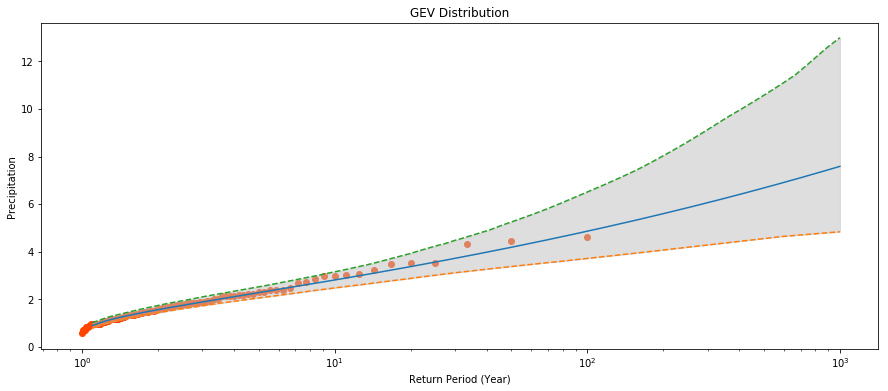

In [9]:
fig, ax = plt.subplots()

plt.setp(ax.lines, linewidth = 2, color = 'magenta')

ax.set_title("GEV Distribution")
ax.set_xlabel("Return Period (Year)")
ax.set_ylabel("Precipitation")
ax.semilogx(T, sT)
ax.scatter(Nmax/N, sorted(df)[::-1], color = 'orangered')

ax.semilogx(T, ci_Td, '--')
ax.semilogx(T, ci_Tu, '--')
ax.fill_between(T, ci_Td, ci_Tu, color = '0.75', alpha = 0.5)

## End Notes

Through this guide I have tried to give you a basic idea how to carry out extreme value analysis (EVA) upon a time series data of interest.

The part 1 shows the basic idea how to carry out extreme value analysis(EVA) from 
* downloading station data using a open source tool of ghcnpy, 
* to check data using pandas and select annual maxima time series, 
* to fit extreme value distributions based on L-moments,
* to present the final output.

The part 2 presents an idea of
* fitting multiple extreme value distributions,
* selecting the best distribution based on a goodness-of-fit measure.

The part 3 shows how to get confidence intervals of the selected distribution's
* its estimated parameters,
* final result (CI at 95% ).

Perhaps, I will introduce a little bit of how to construct extreme precipitation IDF or DDF curves in the next part.

In fact, the analysis will become more complicated in a real practice as high quality data are not always available. Sometimes, you have to spend a lot of time cleaning the data. For example, fill the missing values and check outliers.

This is just a start. You can try more.